In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [2]:
df_modelos = pd.read_csv("../data/datosFinales/diferencias_propagated.csv", sep = ";")
#dropped columns which are 0
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.contains('diferencia')]
categoricas = pd.read_csv("../data/categoricas.csv", sep = ",").squeeze().tolist()
print(len(categoricas))
#remove columns with many NAs
categoricas.remove('tipo_plastia')
categoricas.remove('via_asc_plastia')
print(len(categoricas))

30
28


In [3]:
df_modelos

,id_registro,sexo,edad,peso,talla,imc,neoadyuvancia,localizacion,tipo_histologico,ct,...,linfocitos_5,frec_card_5,plaquetas_5,eva_5,tas_5,leucocitos_5,tad_5,quick_5,sat_oxig_5,albumina_5
0,92-1,0.0,61.0,79.0,178.0,24.9,1.0,4.0,1.0,4.0,...,7.403061,88.0,12.083911,4.0,110.0,8.625330,75.0,105.0,96.0,3.1
1,92-2,1.0,79.0,95.0,170.0,32.9,0.0,4.0,1.0,2.0,...,7.193686,99.0,12.175619,1.0,149.0,9.093919,77.0,105.0,93.0,3.5
2,92-3,0.0,74.0,94.0,175.0,30.7,1.0,4.0,NaN,4.0,...,7.074117,82.0,11.751950,4.0,186.0,8.682877,78.0,105.0,93.0,4.0
3,92-4,0.0,74.0,63.0,168.0,22.3,2.0,3.0,1.0,5.0,...,7.082549,120.0,11.580593,7.0,90.0,9.121618,35.0,105.0,80.0,3.5
4,92-5,0.0,62.0,57.0,157.0,23.1,2.0,4.0,1.0,4.0,...,7.082549,112.0,12.464587,2.0,102.0,8.965845,56.0,105.0,94.0,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,613-30,0.0,72.0,83.0,169.0,29.1,1.0,3.0,1.0,3.0,...,6.552508,91.0,12.185875,3.0,104.0,9.787010,60.0,83.0,97.0,2.4
724,613-31,1.0,40.0,58.0,160.0,22.7,0.0,5.0,1.0,3.0,...,5.638355,77.0,12.417148,2.0,112.0,8.691315,67.0,91.0,98.0,2.4
725,613-32,0.0,59.0,82.0,171.0,28.0,1.0,7.0,1.0,2.0,...,7.467942,56.0,12.842652,0.0,110.0,8.925454,56.0,88.0,98.0,2.4
726,617-1,0.0,74.0,53.0,160.0,20.7,0.0,6.0,2.0,2.0,...,7.244942,67.0,11.925042,3.0,108.0,8.140607,67.0,54.0,94.0,3.1


In [4]:
idPats = np.unique(df_modelos.id_registro)

df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_5')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_4')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_3')]
#df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_2')]

# Modelo Xgboost


In [5]:
np.random.seed(14)

In [6]:
df_tmp = df_modelos.copy()[df_modelos['fuga'] != -1]
cats = []

columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)

y = df_tmp['fuga']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [8]:
# Instanciar el codificador
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Ajustar y transformar las columnas categóricas
X_cat_encoded = encoder.fit_transform(X[cats])

# Crear DataFrame con los nuevos nombres de columnas
cat_encoded_df = pd.DataFrame(
    X_cat_encoded,
    columns=encoder.get_feature_names_out(cats),
    index=X.index  # mantener los índices originales
)

# Concatenar con el resto de columnas no categóricas
X_encoded = pd.concat([X.drop(columns=cats), cat_encoded_df], axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, stratify=y, random_state=14)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=14)

In [10]:
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'error'],
    'max_depth': 4,  # Reducida desde 5
    'learning_rate': 0.001,  # Reducida desde 0.05
    'subsample': 0.3,  # Más bajo para más regularización
    'colsample_bytree': 0.7,
    'min_child_weight': 5,  # Aumentada desde 3
    'gamma': 0.3,  # Aumentada desde 0.2
    'reg_alpha': 2,  # Aumentada desde 1
    'reg_lambda': 15,  # Aumentada desde 10
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1]) * 1.2,  # Balance ajustado
    'seed': 14,
    'tree_method': 'hist'
}


In [11]:

# Encode categorical variables in X_train and X_val
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Convertir a DMatrix

dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded)


#evals_result = {}
model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=2000,  # Más iteraciones posibles
    verbose_eval=50
)



In [12]:
from sklearn.metrics import accuracy_score
#calcula el f1 score del modelo
from sklearn.metrics import f1_score

In [13]:
y_proba_train = model.predict(dtrain)
y_pred_train = (y_proba_train >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_pred_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TRAIN:
[[305  77]
 [ 10  82]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       382
           1       0.52      0.89      0.65        92

    accuracy                           0.82       474
   macro avg       0.74      0.84      0.76       474
weighted avg       0.88      0.82      0.83       474

Accuracy: 0.8164556962025317
AUC: 0.8449
F1 score: 0.6533864541832669


In [14]:
y_proba_test = model.predict(dtest)
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))
#auc
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TEST:
[[104  61]
 [ 15  24]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73       165
           1       0.28      0.62      0.39        39

    accuracy                           0.63       204
   macro avg       0.58      0.62      0.56       204
weighted avg       0.76      0.63      0.67       204

Accuracy: 0.8164556962025317
AUC: 0.7089
F1 score: 0.3870967741935484


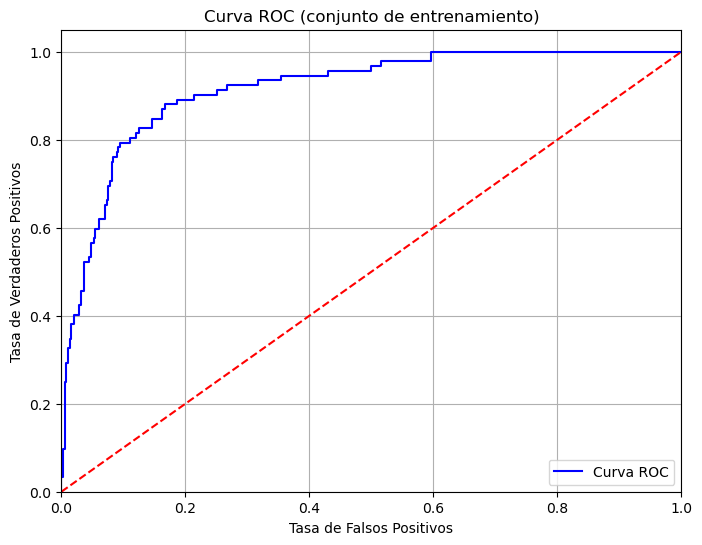

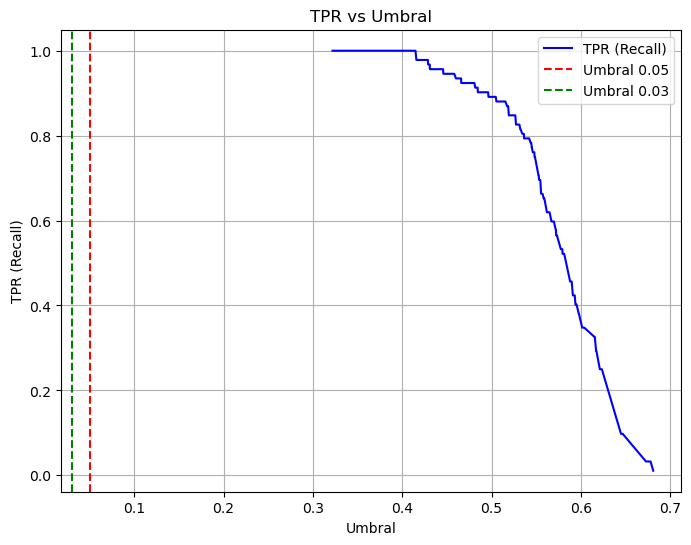

In [15]:
#show the roc curve for the model "modelo_hgb"
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_proba_train, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de entrenamiento)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()




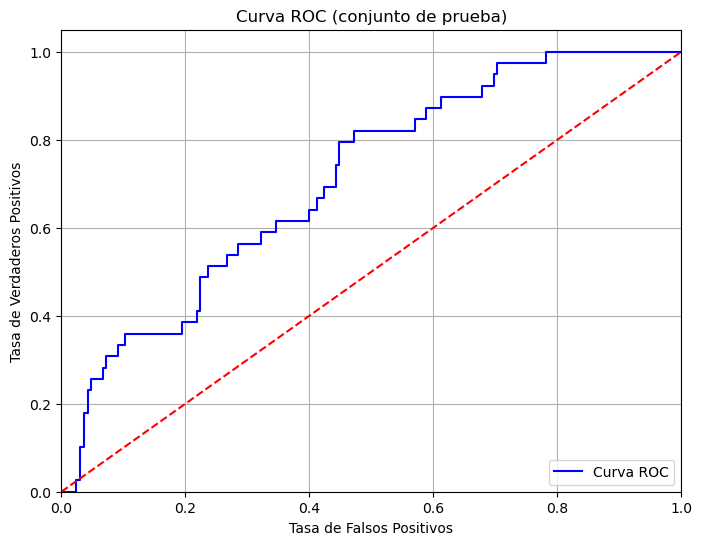

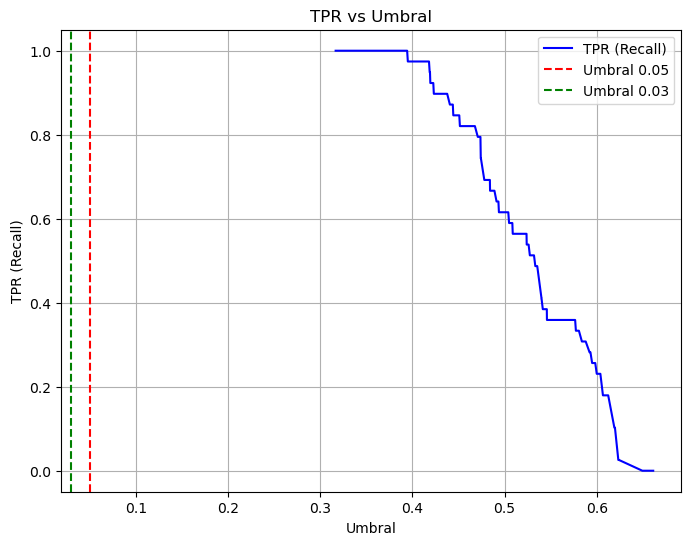

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_test, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de prueba)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()



In [17]:

exp = dx.Explainer(model, X, y)
vi = exp.model_parts() #MIRAR EL METODO!!!
vi.plot(max_vars=20)
#select the 10 most important variables from the explainer
imps = vi.result['variable'][-30:-1].tolist()
imps.append('id_registro')

Preparation of a new explainer is initiated

  -> data              : 678 rows 76 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 678 values
  -> model_class       : xgboost.core.Booster (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_xgboost at 0x14fdcc700> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.317, mean = 0.472, max = 0.681
  -> model type        : 'model_type' not provided and cannot be extracted.
  -> model type        : Some functionalities won't be available.
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.673, mean = -0.279, max = 0.606
  -> model_info        : package xgboost

A new explainer has been created!


In [18]:
print("[")
for i in imps:
    print(",", i)

[
, creatinina_1
, creatinina_2
, leucocitos_2
, peso
, proteinas_2
, tas_0
, tad_2
, plaquetas_1
, linfocitos_2
, talla
, frec_resp_2
, quick_1
, linfocitos_1
, temp_corp_2
, leucocitos_0
, albumina_0
, imc
, proteinas_0
, tad_1
, il6_2
, temp_corp_1
, pcr_1
, tas_1
, quick_2
, pcr_0
, neutrofilos_2
, frec_card_1
, pcr_2
, localizacion
, id_registro


In [19]:
df_imps = df_modelos[imps]
df_imps['fuga'] = df_modelos['fuga']
df_imps['id_registro'] = df_modelos['id_registro']

In [20]:
df_tmp = df_imps.copy()[df_imps['fuga'] != -1]
cats = []
    
columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)
y = df_tmp['fuga']



In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=14)


In [22]:
# for col in cats:
#     if col in X.columns:
#         label_encoder = LabelEncoder()  
#         label_encoder.fit(X[col]) 
#         X[col] = label_encoder.transform(X[col])

# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, 
#     test_size=0.3, 
#     stratify=y, 
#     random_state=14
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_trainval, y_trainval, 
#     test_size=0.2, 
#     stratify=y_trainval, 
#     random_state=14
# )

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# Espacio de búsqueda basado en tus best_params
param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': uniform(0.5, 10),
}

# Codificación de variables categóricas (ya la tienes lista)
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
# Aplica aquí tu codificación si hace falta

# Modelo base
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    seed=14,
    tree_method='hist'
)

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=14,
)

# Entrenamiento
random_search.fit(X_train_encoded, y_train)

# Mejor modelo
best_model = random_search.best_estimator_

# Predicción (si quieres seguir luego con predicciones o evaluación)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [24]:
y_proba_train = best_model.predict_proba(X_train_encoded)[:, 1]
y_pred_train = (y_proba_train >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.39:.4f}")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_proba_train)
print(f"\nAUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.3900

Matriz de confusión TRAIN:
[[380   2]
 [  0  92]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       382
           1       0.98      1.00      0.99        92

    accuracy                           1.00       474
   macro avg       0.99      1.00      0.99       474
weighted avg       1.00      1.00      1.00       474


AUC: 1.0000
Accuracy: 0.9957805907172996
F1 score: 0.989247311827957


0.9411

In [25]:
y_proba_train = best_model.predict_proba(X_test_encoded)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.39:.4f}")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))
#auc
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 score:", f1)



=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.3900

Matriz de confusión TEST:
[[104  61]
 [ 15  24]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73       165
           1       0.28      0.62      0.39        39

    accuracy                           0.63       204
   macro avg       0.58      0.62      0.56       204
weighted avg       0.76      0.63      0.67       204

AUC: 0.7089
Accuracy: 0.6274509803921569
F1 score: 0.3870967741935484


0.7333

In [26]:
exp = dx.Explainer(best_model, X, y)
vi = exp.model_parts()
vi.plot(max_vars=20)


Preparation of a new explainer is initiated

  -> data              : 678 rows 29 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 678 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x14fdcc670> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00434, mean = 0.263, max = 0.973
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.868, mean = -0.07, max = 0.942
  -> model_info        : package xgboost

A new explainer has been created!


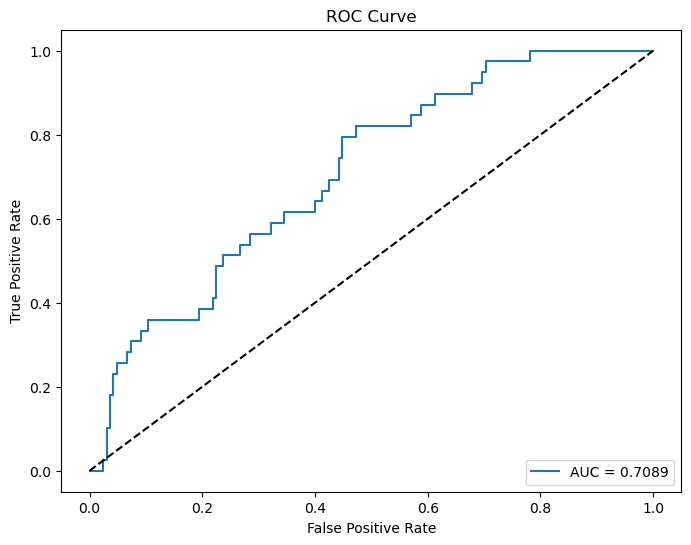

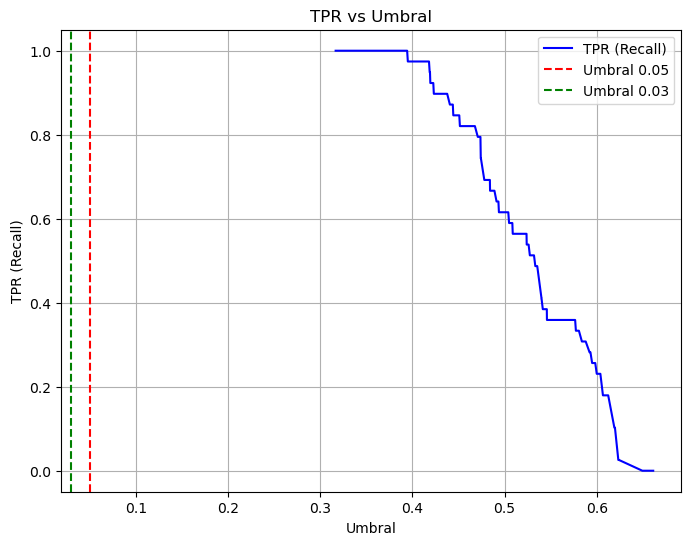

In [51]:
#draw auc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %.4f' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral')
plt.axvline(x=0.05, color='red', linestyle='--', label='Umbral 0.05')
plt.axvline(x=0.03, color='green', linestyle='--', label='Umbral 0.03')
plt.legend()
plt.grid()
plt.show()

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,
    n_estimators=100
)

rf.fit(X_train, y_train)

ensemble_pred = (0.7*y_proba_test + 0.3*rf.predict_proba(X_test)[:,1]) > 0.39
y_pred_ensemble = ensemble_pred.astype(int)

# Generar reporte de clasificación completo
print("\n=== RESULTADOS DEL ENSEMBLE ===")
print("Matriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_ensemble))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_ensemble, zero_division=0))
print(f"AUC-ROC Ensemble: {roc_auc_score(y_test, 0.7*y_proba_test + 0.3*rf.predict_proba(X_test)[:,1]):.4f}")


=== RESULTADOS DEL ENSEMBLE ===
Matriz de confusión TEST:
[[ 64 101]
 [  4  35]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.94      0.39      0.55       165
           1       0.26      0.90      0.40        39

    accuracy                           0.49       204
   macro avg       0.60      0.64      0.47       204
weighted avg       0.81      0.49      0.52       204

AUC-ROC Ensemble: 0.7139
